# Test ENL maps

Highlights the importance of the SAR distribution in the computation of the ENL maps.

The ENL at a pixel is usually estimated as the square ratio between sample mean and standard deviation computed on an N × N window surrounding the pixel. The value of N trades off reliability for spatial resolution. A small value of N guarantees a good resolution, but the resulting ENL map is extremely noisy, whereas a large value of N improves the estimation at the cost of a significant loss of resolution.


f(t) → 1 in flat homogeneous regions and f(t) → 0 in man-made areas

In [1]:
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import scipy.io
from typing import Tuple
from tqdm import tqdm

print(jax.devices())

[CpuDevice(id=0)]


In [2]:
GAMMA = 7
A0 = 0.64

In [3]:
def T(sar: np.ndarray) -> np.ndarray:
    sar = jnp.array(sar)
    sar = 20 * np.log1p(np.abs(sar))
    sar = (sar - sar.min()) / (sar.max() - sar.min())  # Normalize to [0, 1]
    if sar.ndim == 2:
        sar = jnp.expand_dims(sar, axis=-1)  # (H, W) -> (H, W, 1)
    return sar


def invT(sar: np.ndarray, scale: float = 255.) -> np.ndarray:
    sar = jnp.array(sar)
    sar = sar * scale
    sar = jnp.expm1(sar / 20)
    return sar


def rgb2gray(rgb: jnp.ndarray) -> jnp.ndarray:
    """Convert RGB image to grayscale."""
    return jnp.dot(rgb[..., :3], jnp.array([1./3.] * 3))


def extract_patches(
        tensor: jnp.ndarray, 
        kernel_size: int,
        start_index: Tuple[int, int],
        end_indices: Tuple[int, int]) -> jnp.ndarray:
    D = tensor.shape[2:]  # Tuple corresponding to the size of the descriptor, which can be empty if input tensor is 2D
    pad = kernel_size // 2  # Integer, the pad size usually corresponds to half the size of the kernel

    # Pad the input tensor to handle borders. The last part '((0, 0),) * len(D)' allows to handle N-D tensors.
    tensor = jnp.pad(tensor, ((pad, pad), (pad, pad)) + ((0, 0),) * len(D), mode='reflect')

    # Create indices for the sliding window
    h_idx = jnp.arange(start_index[0], end_indices[0])
    w_idx = jnp.arange(start_index[1], end_indices[1])

    # Create a function to extract patches for each (i, j) pair
    def get_patch(i: int, j: int) -> jnp.ndarray:
        patch = jax.lax.dynamic_slice(operand=tensor, 
                                      start_indices=(i, j) + (0,)*len(D), 
                                      slice_sizes=(kernel_size, kernel_size) + D)
        return patch

    # Use vmap to vectorize the extraction of patches across the height and width indices
    patches = jax.vmap(
        lambda i: jax.vmap(lambda j: get_patch(i, j))(w_idx)
    )(h_idx)
    return patches 

## Test on data 1

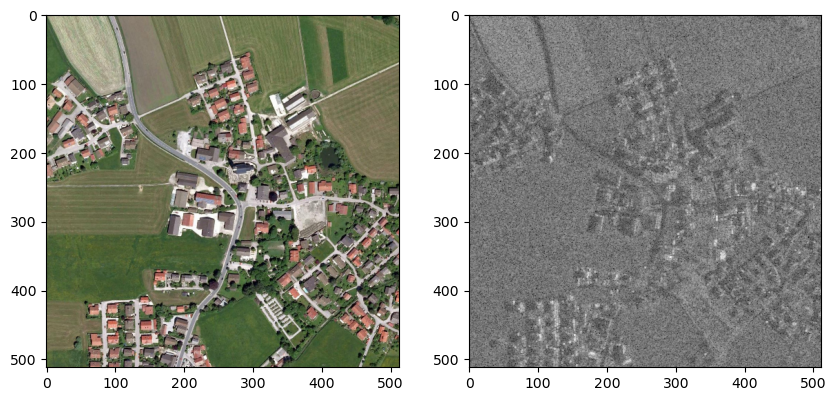

In [4]:
input_path = "../../dataset/clip_T1.mat"
data = scipy.io.loadmat(input_path)

guide = data['guide']
noisy = data['noisy']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(guide)
plt.subplot(1, 2, 2)
plt.imshow(T(noisy), cmap='gray')

### Test on sar = noisy

In [5]:
window_size_list = np.arange(7, 35, 2).tolist()
sar = noisy

enl_list = []
for window_size in tqdm(window_size_list):
    radius = window_size // 2
    sar_padded = jnp.pad(sar, ((radius, radius), (radius, radius)), mode='reflect')  # (H', W')

    # Extract patches
    patches = extract_patches(sar_padded, window_size, (0, 0), sar_padded.shape[:2])  # (H', W', k, k)

    # Compute local mean and variance
    local_mean = patches.mean(axis=(-2, -1))  # (H', W')
    local_var = patches.var(axis=(-2, -1))  # (H', W')

    # Compute ENL
    enl = local_mean**2 / (local_var + 1e-10)  # Avoid division by zero
    enl = enl[radius:-radius, radius:-radius]  # Unpad to get output of shape (H, W)
    enl_list.append(enl)

enl_avg = jnp.mean(jnp.stack(enl_list, axis=0), axis=0)
ft = 1. / (1 + jnp.exp(-GAMMA * (enl_avg - A0)))
print(len(enl_list))

100%|██████████| 14/14 [00:07<00:00,  1.92it/s]

14


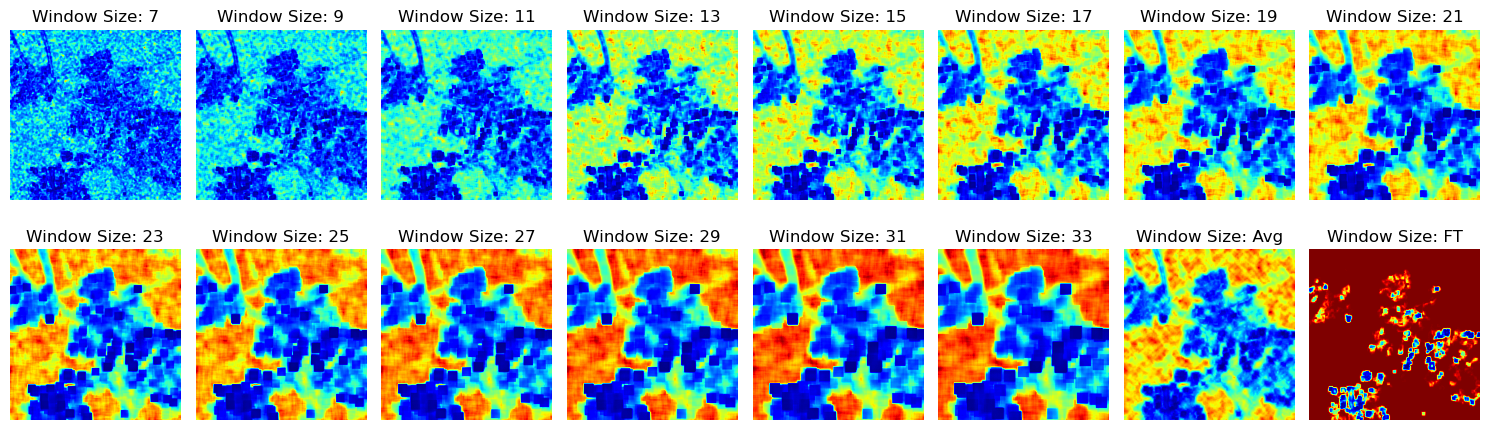

In [6]:
enl_list.append(enl_avg)
enl_list.append(ft)

plt.figure(figsize=(15, 9))
for i, window_size in enumerate(window_size_list + ['Avg', 'FT']):
    plt.subplot(4, 8, i + 1)
    plt.imshow(enl_list[i], cmap='jet')
    plt.title(f'Window Size: {window_size}')
    plt.axis('off')

plt.tight_layout()

In [7]:
enl_avg.min(), enl_avg.max(), ft.min(), ft.max()

(Array(0.11533396, dtype=float32),
 Array(5.1381445, dtype=float32),
 Array(0.02477914, dtype=float32),
 Array(1., dtype=float32))

### Test on sar = T(noisy)

In [8]:
window_size_list = np.arange(7, 35, 2).tolist()
sar = T(noisy).squeeze()

enl_list = []
for window_size in tqdm(window_size_list):
    radius = window_size // 2
    sar_padded = jnp.pad(sar, ((radius, radius), (radius, radius)), mode='reflect')  # (H', W')

    # Extract patches
    patches = extract_patches(sar_padded, window_size, (0, 0), sar_padded.shape[:2])  # (H', W', k, k)

    # Compute local mean and variance
    local_mean = patches.mean(axis=(-2, -1))  # (H', W')
    local_var = patches.var(axis=(-2, -1))  # (H', W')

    # Compute ENL
    enl = local_mean**2 / (local_var + 1e-10)  # Avoid division by zero
    enl = enl[radius:-radius, radius:-radius]  # Unpad to get output of shape (H, W)
    enl_list.append(enl)

enl_avg = jnp.mean(jnp.stack(enl_list, axis=0), axis=0)
ft = 1. / (1 + jnp.exp(-GAMMA * (enl_avg - A0)))
print(len(enl_list))

100%|██████████| 14/14 [00:01<00:00,  8.28it/s]

14


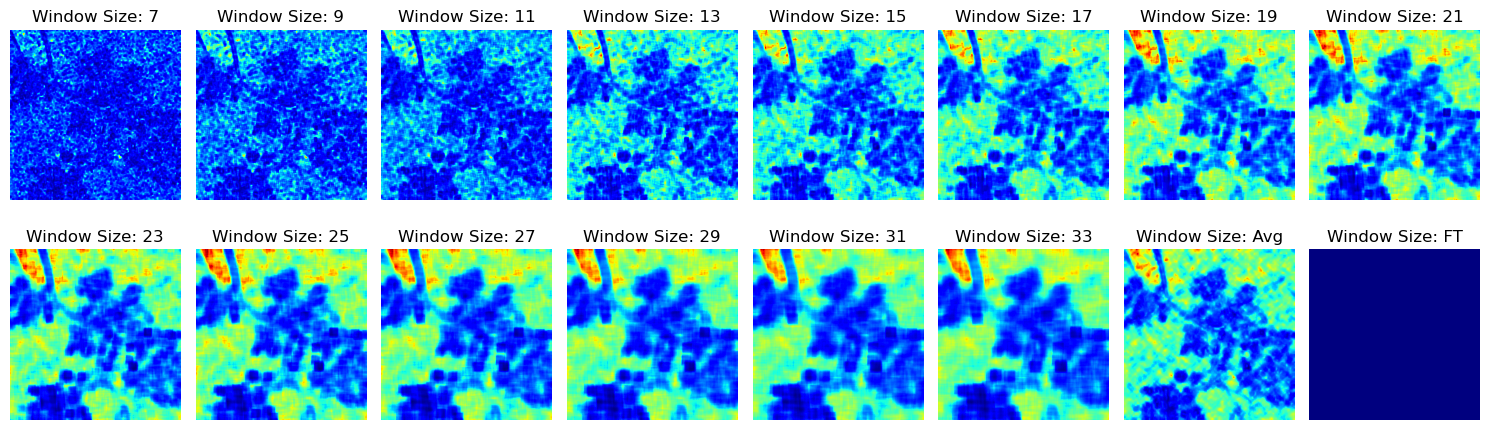

In [9]:
enl_list.append(enl_avg)
enl_list.append(ft)

plt.figure(figsize=(15, 9))
for i, window_size in enumerate(window_size_list + ['Avg', 'FT']):
    plt.subplot(4, 8, i + 1)
    plt.imshow(enl_list[i], cmap='jet')
    plt.title(f'Window Size: {window_size}')
    plt.axis('off')

plt.tight_layout()

In [10]:
enl_avg.min(), enl_avg.max(), ft.min(), ft.max()

(Array(11.464758, dtype=float32),
 Array(91.83871, dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32))

## Test on data 2

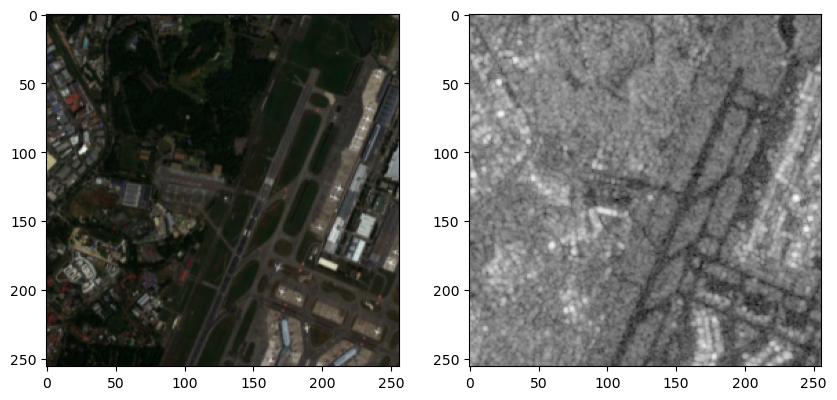

In [11]:
input_path = "../data/data.npz"
data = np.load(input_path)

guide = data['eo']
noisy = data['sar']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(guide)
plt.subplot(1, 2, 2)
plt.imshow(T(noisy), cmap='gray')

### Test on sar = noisy

In [12]:
window_size_list = np.arange(7, 35, 2).tolist()
sar = noisy.squeeze()

enl_list = []
for window_size in tqdm(window_size_list):
    radius = window_size // 2
    sar_padded = jnp.pad(sar, ((radius, radius), (radius, radius)), mode='reflect')  # (H', W')

    # Extract patches
    patches = extract_patches(sar_padded, window_size, (0, 0), sar_padded.shape[:2])  # (H', W', k, k)

    # Compute local mean and variance
    local_mean = patches.mean(axis=(-2, -1))  # (H', W')
    local_var = patches.var(axis=(-2, -1))  # (H', W')

    # Compute ENL
    enl = local_mean**2 / (local_var + 1e-10)  # Avoid division by zero
    enl = enl[radius:-radius, radius:-radius]  # Unpad to get output of shape (H, W)
    enl_list.append(enl)

enl_avg = jnp.mean(jnp.stack(enl_list, axis=0), axis=0)
ft = 1. / (1 + jnp.exp(-GAMMA * (enl_avg - A0)))
print(len(enl_list))

100%|██████████| 14/14 [00:04<00:00,  3.12it/s]

14


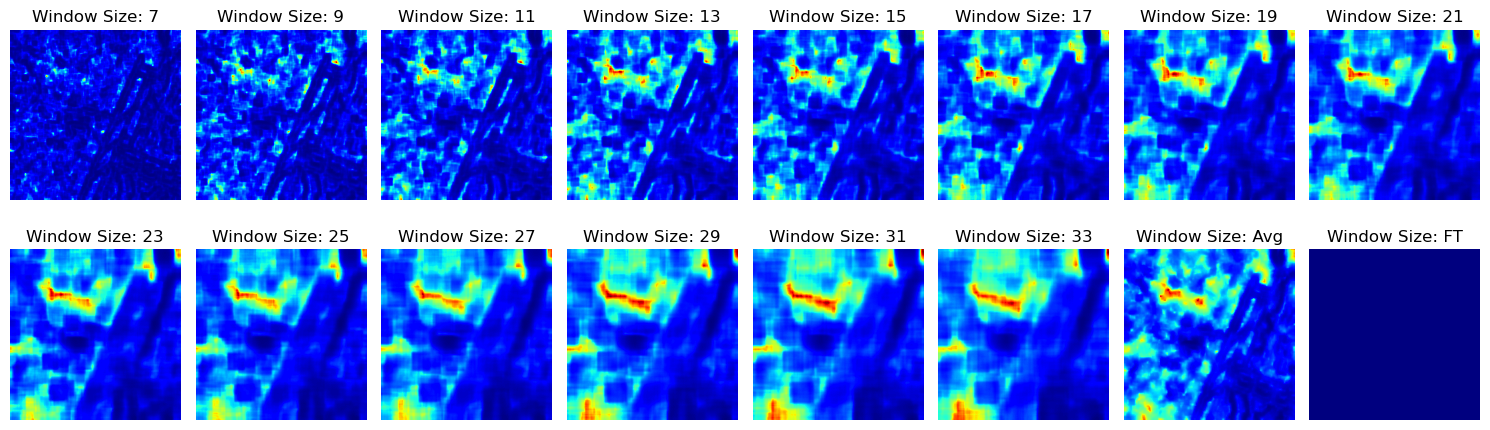

In [13]:
enl_list.append(enl_avg)
enl_list.append(ft)

plt.figure(figsize=(15, 9))
for i, window_size in enumerate(window_size_list + ['Avg', 'FT']):
    plt.subplot(4, 8, i + 1)
    plt.imshow(enl_list[i], cmap='jet')
    plt.title(f'Window Size: {window_size}')
    plt.axis('off')

plt.tight_layout()

In [14]:
enl_avg.min(), enl_avg.max(), ft.min(), ft.max()

(Array(4.8603053, dtype=float32),
 Array(146.7791, dtype=float32),
 Array(1., dtype=float32),
 Array(1., dtype=float32))

## Test on sar = invT(noisy)

In [15]:
window_size_list = np.arange(7, 35, 2).tolist()
sar = invT(noisy).squeeze()

enl_list = []
for window_size in tqdm(window_size_list):
    radius = window_size // 2
    sar_padded = jnp.pad(sar, ((radius, radius), (radius, radius)), mode='reflect')  # (H', W')

    # Extract patches
    patches = extract_patches(sar_padded, window_size, (0, 0), sar_padded.shape[:2])  # (H', W', k, k)

    # Compute local mean and variance
    local_mean = patches.mean(axis=(-2, -1))  # (H', W')
    local_var = patches.var(axis=(-2, -1))  # (H', W')

    # Compute ENL
    enl = local_mean**2 / (local_var + 1e-10)  # Avoid division by zero
    enl = enl[radius:-radius, radius:-radius]  # Unpad to get output of shape (H, W)
    enl_list.append(enl)

enl_avg = jnp.mean(jnp.stack(enl_list, axis=0), axis=0)
ft = 1. / (1 + jnp.exp(-GAMMA * (enl_avg - A0)))
print(len(enl_list))

100%|██████████| 14/14 [00:00<00:00, 14.73it/s]

14


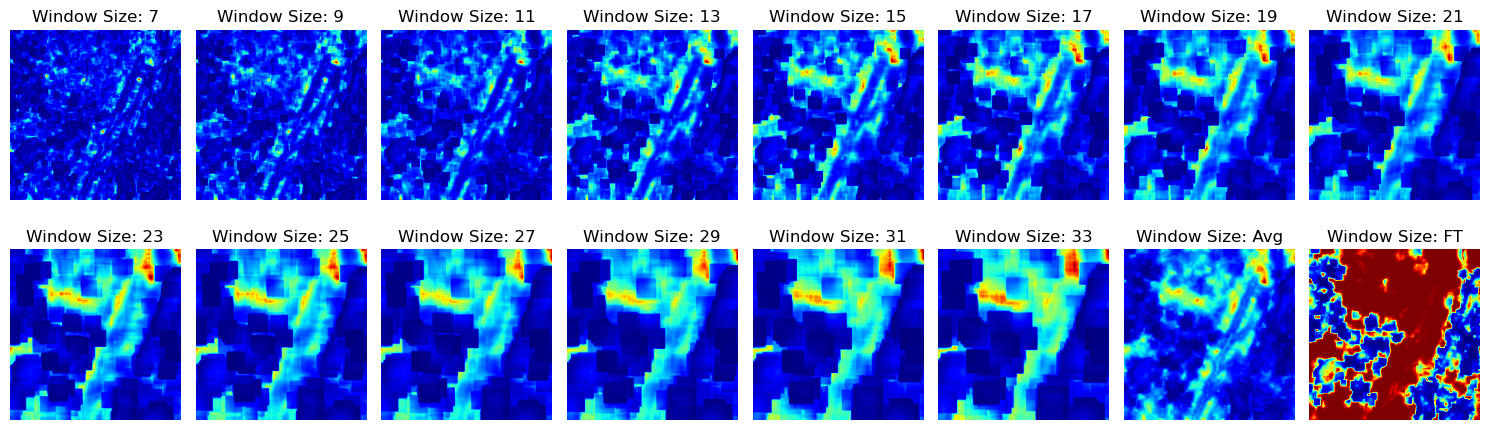

In [16]:
enl_list.append(enl_avg)
enl_list.append(ft)

plt.figure(figsize=(15, 9))
for i, window_size in enumerate(window_size_list + ['Avg', 'FT']):
    plt.subplot(4, 8, i + 1)
    plt.imshow(enl_list[i], cmap='jet')
    plt.title(f'Window Size: {window_size}')
    plt.axis('off')

plt.tight_layout()

In [17]:
enl_avg.min(), enl_avg.max(), ft.min(), ft.max()

(Array(0.04459498, dtype=float32),
 Array(6.008493, dtype=float32),
 Array(0.0152496, dtype=float32),
 Array(1., dtype=float32))